### 데이터 불러오기 및 확인

In [45]:
from google.colab import drive
drive.mount("/content/drive")

FOLDERNAME = "/content/drive/MyDrive/Colab Notebooks/25학년 1학기/딥러닝/딥러닝 프로젝트"

import sys
sys.path.append(FOLDERNAME)
%cd $FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/25학년 1학기/딥러닝/딥러닝 프로젝트


In [46]:
!pip install jsonlines

In [55]:
import jsonlines
import pandas as pd

# id 정보를 모아서 저장하는 예시
train_dict = {
    'id' : [],
    'sentence_form' : [],
    'annotation' : []
}

# open 내의 디렉토리 및 파일 이름에 유의
with jsonlines.open('nikluge-sa-2022-train.jsonl') as f:
    for line in f:
        train_dict['id'].append(line['id'])
        train_dict['sentence_form'].append(line['sentence_form'])
        train_dict['annotation'].append(line['annotation'])

valid_dict ={
    'id' : [],
    'sentence_form' : [],
    'annotation' : []
}

with jsonlines.open('nikluge-sa-2022-dev.jsonl') as f:
    for line in f:
        valid_dict['id'].append(line['id'])
        valid_dict['sentence_form'].append(line['sentence_form'])
        valid_dict['annotation'].append(line['annotation'])

In [56]:
train_df = pd.DataFrame(train_dict)
valid_df = pd.DataFrame(train_dict)

In [57]:
display(train_df.tail())
display(valid_df.tail())

,id,sentence_form,annotation
2996,nikluge-sa-2022-train-02997,(슬픔),"[[제품 전체#가격, [None, 0, 0], negative]]"
2997,nikluge-sa-2022-train-02998,보드랍고 괜찮다!,"[[제품 전체#품질, [None, 0, 0], positive]]"
2998,nikluge-sa-2022-train-02999,#일본 유니클로 질이 우리나라보다 좋은 것 같으면 기분 탓인가.......,"[[브랜드#일반, [유니클로, 4, 8], neutral]]"
2999,nikluge-sa-2022-train-03000,마지막으로 귀여워서 집어온 모자.,"[[제품 전체#디자인, [모자, 15, 17], positive]]"
3000,nikluge-sa-2022-train-03001,일본유니클로 사랑해!!!!!!!,"[[브랜드#일반, [일본유니클로, 0, 6], positive]]"


,id,sentence_form,annotation
2996,nikluge-sa-2022-train-02997,(슬픔),"[[제품 전체#가격, [None, 0, 0], negative]]"
2997,nikluge-sa-2022-train-02998,보드랍고 괜찮다!,"[[제품 전체#품질, [None, 0, 0], positive]]"
2998,nikluge-sa-2022-train-02999,#일본 유니클로 질이 우리나라보다 좋은 것 같으면 기분 탓인가.......,"[[브랜드#일반, [유니클로, 4, 8], neutral]]"
2999,nikluge-sa-2022-train-03000,마지막으로 귀여워서 집어온 모자.,"[[제품 전체#디자인, [모자, 15, 17], positive]]"
3000,nikluge-sa-2022-train-03001,일본유니클로 사랑해!!!!!!!,"[[브랜드#일반, [일본유니클로, 0, 6], positive]]"


### 데이터 가공

In [58]:
train_df['len'] = train_df.annotation.apply(lambda x : len(x))
valid_df['len'] = valid_df.annotation.apply(lambda x : len(x))

In [59]:
import re
def get_only_hangul(line):
    return re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣\s]', '', line)
train_df['sentence_form'] = train_df['sentence_form'].apply(get_only_hangul)

In [60]:
import numpy as np
np.unique(train_df['len'], return_counts = True)

(array([1, 2, 3, 4, 5]), array([2766,  221,   10,    3,    1]))

In [61]:
def expand_row(row):
    labels = row["annotation"]
    if len(labels) >= 2:
        # 리스트 길이만큼 복사
        return pd.DataFrame({
            "id": [row["id"]] * len(labels),
            "sentence_form" : row['sentence_form'] * len(labels),
            "label": labels,
            "annotation_len": len(labels)
        })
    else:
        return pd.DataFrame({
            "id": [row["id"]],
            "sentence_form" : row['sentence_form'],
            "label": labels,
            "annotation_len" : 1
        })

train_df = pd.concat(train_df.apply(expand_row, axis=1).tolist(), ignore_index=True)
valid_df = pd.concat(valid_df.apply(expand_row, axis=1).tolist(), ignore_index=True)

In [62]:
def extract_ACD_entity(row):
    return row[0].split("#")[0]

def extract_ACD_attribute(row):
    return row[0].split("#")[1]

def extract_ACD_word(row):
    return row[1][0]

train_df['ACD_entity'] = train_df.label.apply(extract_ACD_entity)
train_df['ACD_attribute'] = train_df.label.apply(extract_ACD_attribute)
train_df['ACD_word'] = train_df.label.apply(extract_ACD_word)

valid_df['ACD_entity'] = valid_df.label.apply(extract_ACD_entity)
valid_df['ACD_attribute'] = valid_df.label.apply(extract_ACD_attribute)
valid_df['ACD_word'] = valid_df.label.apply(extract_ACD_word)

In [63]:
entity_cnt = train_df.ACD_entity.value_counts()
attribute_cnt = train_df.ACD_attribute.value_counts()

### 데이터 증강

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

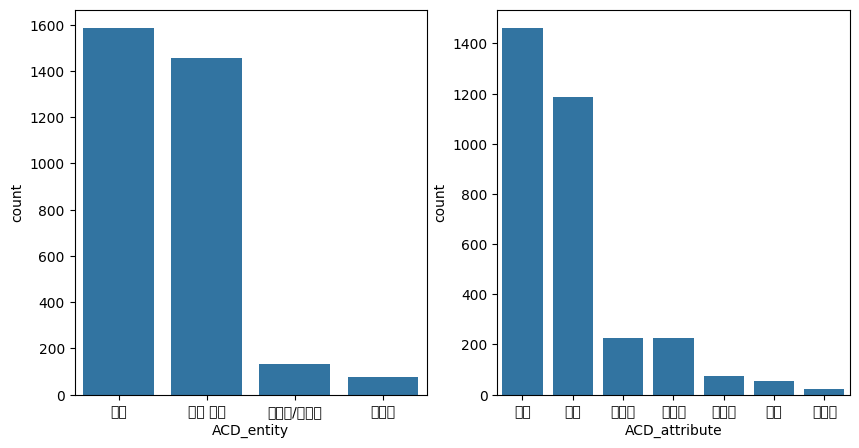

In [65]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
import seaborn as sns

fig, ax = plt.subplots(1,2, figsize = (10,5))
sns.barplot(data = entity_cnt, ax = ax[0])
sns.barplot(data = attribute_cnt, ax = ax[1])
plt.show()

In [66]:
from sklearn.utils import resample
import pandas as pd
import numpy as np
from eda import EDA

def augment_group(df_group, target_size, num_aug=9):
    """ 그룹 내 문장 증강하여 target_size까지 늘리기 """
    sentences = df_group['sentence_form'].tolist()
    augmented_sentences = set(sentences)  # 시작부터 원본 문장 포함

    # 현재 문장 수가 target_size보다 적을 때만 증강 진행
    if len(augmented_sentences) < target_size:
        # 각 문장에 대해 EDA 수행
        for sent in sentences:
            try:
                # EDA 함수가 리스트를 반환한다고 가정
                augmented = EDA(sent, num_aug=num_aug)
                augmented_sentences.update(augmented)  # set에 추가

                # 충분한 수의 문장이 생성되면 중단
                if len(augmented_sentences) >= target_size:
                    break
            except Exception as e:
                print(f"EDA 오류 발생: {e} - 문장: {sent}")
                continue

    # set에서 리스트로 변환
    augmented_sentences = list(augmented_sentences)

    # 중복 제거 후에도 부족하면 원본 문장 복사해서 늘림
    if len(augmented_sentences) < target_size:
        needed = target_size - len(augmented_sentences)
        # 원본 문장을 반복해서 추가
        additional_sentences = np.random.choice(sentences, size=needed, replace=True)
        augmented_sentences.extend(additional_sentences)

    # 너무 많으면 자르기
    augmented_sentences = augmented_sentences[:target_size]

    # 원본 그룹에서 모든 행 복제
    repeated_indices = np.random.choice(df_group.index, size=target_size, replace=True)
    new_df = df_group.loc[repeated_indices].copy()

    # 문장만 새로운 것으로 교체
    new_df['sentence_form'] = augmented_sentences

    return new_df

# 1) 그룹별 최대 개수 구하기 (0 제외)
group_counts = train_df.groupby(['ACD_entity', 'ACD_attribute']).size()
max_count = group_counts[group_counts > 0].max()
print(f"목표 그룹 크기: {max_count}")

augmented_list = []

# 2) 그룹별 EDA 증강 적용
for (entity, attr), group in train_df.groupby(['ACD_entity', 'ACD_attribute']):
    current_len = len(group)

    if current_len < max_count:
        # 증강해서 max_count까지 맞추기
        augmented_group = augment_group(group, max_count)
        augmented_list.append(augmented_group)
    else:
        # 이미 max_count 이상이면 다운샘플링
        sampled_group = resample(group, replace=False, n_samples=max_count, random_state=42)
        augmented_list.append(sampled_group)

# 3) 합치기
upasampled_df = pd.concat(augmented_list).reset_index(drop=True)
print(f"최종 데이터 크기: {len(upasampled_df)}")

목표 그룹 크기: 1196
최종 데이터 크기: 26312


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

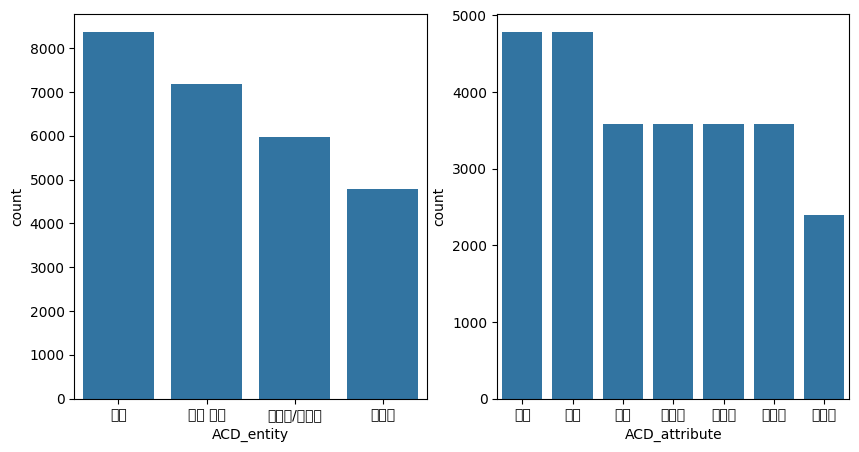

In [67]:
entity_cnt = upasampled_df.ACD_entity.value_counts()
attribute_cnt = upasampled_df.ACD_attribute.value_counts()

import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
import seaborn as sns

fig, ax = plt.subplots(1,2, figsize = (10,5))
sns.barplot(data = entity_cnt, ax = ax[0])
sns.barplot(data = attribute_cnt, ax = ax[1])
plt.show()

In [68]:
from sklearn.utils import resample
import pandas as pd

# (1) 조합별 개수 확인
group_counts = upasampled_df.groupby(['ACD_entity', 'ACD_attribute']).size()

# (2) 최소 수치로 맞춤 (0은 제외)
min_count = group_counts[group_counts > 0].min()

# (3) 조합별 다운샘플링 수행
downsampled_list = []

for (entity, attr), group in upasampled_df.groupby(['ACD_entity', 'ACD_attribute']):
    if len(group) >= min_count:
        sampled = resample(group, replace=False, n_samples=min_count, random_state=42)
        downsampled_list.append(sampled)

# (4) 합치기
final_df = pd.concat(downsampled_list).reset_index(drop=True)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

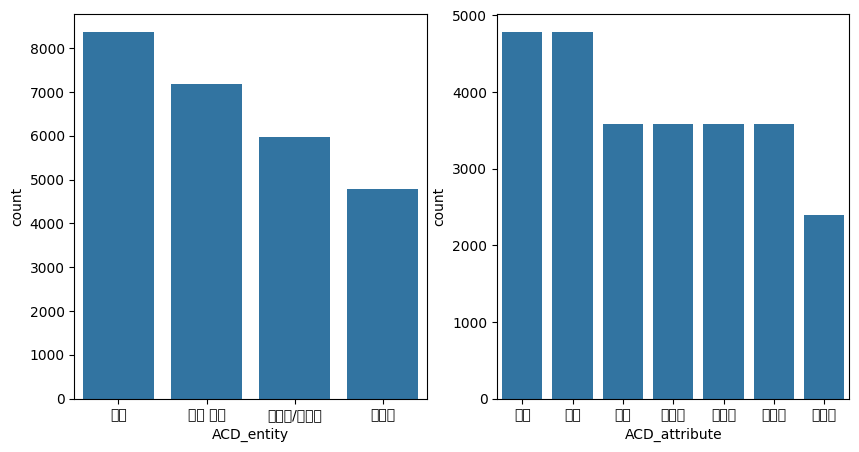

In [69]:
entity_cnt = final_df.ACD_entity.value_counts()
attribute_cnt = final_df.ACD_attribute.value_counts()

import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
import seaborn as sns

fig, ax = plt.subplots(1,2, figsize = (10,5))
sns.barplot(data = entity_cnt, ax = ax[0])
sns.barplot(data = attribute_cnt, ax = ax[1])
plt.show()

### roberta model 불러오기

In [70]:
from transformers import AutoTokenizer, AutoModel

In [71]:
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-base")
model = AutoModel.from_pretrained("klue/roberta-base")

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 데이터셋 형성

In [73]:
from torch.utils.data import Dataset
import torch

class MultiTaskDataset(Dataset):
    def __init__(self, texts, entity_labels, attribute_labels, len_labels, tokenizer, max_len):
        self.texts = texts
        self.entity_labels = entity_labels
        self.attribute_labels = attribute_labels
        self.len_labels = len_labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        entity_label = torch.tensor(self.entity_labels[idx], dtype=torch.long)
        attribute_label = torch.tensor(self.attribute_labels[idx], dtype=torch.long)
        len_label = torch.tensor(self.len_labels[idx], dtype=torch.float32)

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'entity_label': entity_label,
            'attribute_label': attribute_label,
            'len_label' : len_label
        }


from sklearn.preprocessing import LabelEncoder

le_entity = LabelEncoder()
le_attribute = LabelEncoder()

train_entity_labels = le_entity.fit_transform(final_df['ACD_entity'])
train_attribute_labels = le_attribute.fit_transform(final_df['ACD_attribute'])

valid_entity_labels = le_entity.transform(valid_df['ACD_entity'])
valid_attribute_labels = le_attribute.transform(valid_df['ACD_attribute'])

from torch.utils.data import DataLoader

train_dataset = MultiTaskDataset(
    texts=final_df['sentence_form'].tolist(),
    entity_labels=train_entity_labels,
    attribute_labels=train_attribute_labels,
    len_labels=final_df['annotation_len'],
    tokenizer=tokenizer,
    max_len=64
)

valid_dataset = MultiTaskDataset(
    texts=valid_df['sentence_form'].tolist(),
    entity_labels=valid_entity_labels,
    attribute_labels=valid_attribute_labels,
    len_labels=valid_df['annotation_len'],
    tokenizer=tokenizer,
    max_len=64
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [74]:
import torch
import torch.nn as nn
from transformers import AutoModel, get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import os
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Bert_Classifier(nn.Module):
    def __init__(self, model_name="klue/roberta-base"):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)

        # 문제 확인을 위한 차원 출력
        hidden_size = self.bert.config.hidden_size
        print(f"BERT hidden size: {hidden_size}")

        self.classifier1 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size//2, 4)  # entity: 4 classes
        )

        self.classifier2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size//2, 7)  # attribute: 7 classes
        )

        self.classifier3 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size//2, 1)  # length: regression
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state[:, 0, :]  # [CLS] 토큰 표현

        output1 = self.classifier1(x)
        output2 = self.classifier2(x)
        output3 = self.classifier3(x)

        return output1, output2, output3

def train_validate_model(model, train_loader, val_loader, optimizer, scheduler=None,
                         epochs=10, task_weights=[1.0, 1.0, 0.1],
                         patience=3, checkpoint_dir='checkpoints'):
    """
    모델 학습 및 검증 함수

    Args:
        model: 학습할 모델
        train_loader: 학습 데이터 로더
        val_loader: 검증 데이터 로더
        optimizer: 옵티마이저
        scheduler: 학습률 스케줄러 (선택 사항)
        epochs: 학습할 에폭 수
        task_weights: 각 태스크의 손실 가중치 [entity, attribute, length]
        patience: 조기 종료를 위한 인내심 (이 값만큼 검증 손실이 개선되지 않으면 학습 중단)
        checkpoint_dir: 모델 체크포인트 저장 경로

    Returns:
        train_history: 학습 손실 기록
        val_history: 검증 손실 기록
        best_model: 최상의 성능을 보인 모델
    """

    # 체크포인트 디렉토리 생성
    os.makedirs(checkpoint_dir, exist_ok=True)

    # 손실 함수 정의
    ce_loss = nn.CrossEntropyLoss()
    mse_loss = nn.MSELoss()

    # 학습 손실 기록
    train_history = {
        'entity_loss': [],
        'attribute_loss': [],
        'number_loss': [],
        'total_loss': []
    }
    val_history = {
        'entity_loss': [],
        'attribute_loss': [],
        'number_loss': [],
        'total_loss': []
    }

    # 조기 종료를 위한 변수들
    best_val_loss = float('inf')
    counter = 0
    best_model = None

    for epoch in range(epochs):
        total_train_loss = 0
        total_train_entity_loss = 0
        total_train_attribute_loss = 0
        total_train_number_loss = 0

        total_val_loss = 0
        total_val_entity_loss = 0
        total_val_attribute_loss = 0
        total_val_number_loss = 0

        # 진행률 표시
        progress_bar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        progress_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Valid]")

        model.train()

        for batch in progress_bar_train:
            # 배치 데이터를 GPU로 이동
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            entity_label = batch['entity_label'].to(device)
            attribute_label = batch['attribute_label'].to(device)
            len_label = batch['len_label'].view(-1, 1).to(device)

            # 그래디언트 초기화
            optimizer.zero_grad()

            try:
                # 모델 예측
                entity_logits, attribute_logits, number_pred = model(input_ids, attention_mask)

                # 손실 계산
                entity_loss = ce_loss(entity_logits, entity_label)
                attribute_loss = ce_loss(attribute_logits, attribute_label)
                number_loss = mse_loss(number_pred, len_label)

                # 태스크 가중치 적용
                w1, w2, w3 = task_weights
                combined_loss = (w1 * entity_loss) + (w2 * attribute_loss) + (w3 * number_loss)

                # 역전파
                combined_loss.backward()

                # 그래디언트 클리핑 (선택적)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                # 가중치 업데이트
                optimizer.step()

                # 학습률 스케줄러 업데이트
                if scheduler is not None:
                    scheduler.step()

                # 손실 기록
                curr_entity_loss = entity_loss.item()
                curr_attribute_loss = attribute_loss.item()
                curr_number_loss = number_loss.item()
                curr_total_loss = combined_loss.item()

                total_train_entity_loss += curr_entity_loss
                total_train_attribute_loss += curr_attribute_loss
                total_train_number_loss += curr_number_loss
                total_train_loss += curr_total_loss

                # tqdm 진행률 표시 업데이트
                progress_bar_train.set_postfix({
                    'entity_loss': f"{curr_entity_loss:.4f}",
                    'attr_loss': f"{curr_attribute_loss:.4f}",
                    'number_loss': f"{curr_number_loss:.4f}",
                    'total_loss': f"{curr_total_loss:.4f}"
                })

            except Exception as e:
                print(f"Error during training: {e}")
                continue

        # 에폭 평균 손실 계산
        avg_train_entity_loss = total_train_entity_loss / len(train_loader)
        avg_train_attribute_loss = total_train_attribute_loss / len(train_loader)
        avg_train_number_loss = total_train_number_loss / len(train_loader)
        avg_train_total_loss = total_train_loss / len(train_loader)

        # 손실 히스토리에 추가
        train_history['entity_loss'].append(avg_train_entity_loss)
        train_history['attribute_loss'].append(avg_train_attribute_loss)
        train_history['number_loss'].append(avg_train_number_loss)
        train_history['total_loss'].append(avg_train_total_loss)

        # 검증
        # -----------------------------------------------------------

        model.eval()

        for batch in progress_bar_val:
            # 배치 데이터를 GPU로 이동
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            entity_label = batch['entity_label'].to(device)
            attribute_label = batch['attribute_label'].to(device)
            len_label = batch['len_label'].view(-1, 1).to(device)

            with torch.no_grad():
              try:
                  # 모델 예측
                  entity_logits, attribute_logits, number_pred = model(input_ids, attention_mask)

                  # 손실 계산
                  entity_loss = ce_loss(entity_logits, entity_label)
                  attribute_loss = ce_loss(attribute_logits, attribute_label)
                  number_loss = mse_loss(number_pred, len_label)

                  # 태스크 가중치 적용
                  w1, w2, w3 = task_weights
                  combined_loss = (w1 * entity_loss) + (w2 * attribute_loss) + (w3 * number_loss)

                  # 손실 기록
                  curr_entity_loss = entity_loss.item()
                  curr_attribute_loss = attribute_loss.item()
                  curr_number_loss = number_loss.item()
                  curr_total_loss = combined_loss.item()

                  total_val_entity_loss += curr_entity_loss
                  total_val_attribute_loss += curr_attribute_loss
                  total_val_number_loss += curr_number_loss
                  total_val_loss += curr_total_loss

                  # tqdm 진행률 표시 업데이트
                  progress_bar_val.set_postfix({
                      'entity_loss': f"{curr_entity_loss:.4f}",
                      'attr_loss': f"{curr_attribute_loss:.4f}",
                      'number_loss': f"{curr_number_loss:.4f}",
                      'total_loss': f"{curr_total_loss:.4f}"
                  })

              except Exception as e:
                  print(f"Error during validation: {e}")
                  continue

        # 에폭 평균 손실 계산
        avg_val_entity_loss = total_val_entity_loss / len(val_loader)
        avg_val_attribute_loss = total_val_attribute_loss / len(val_loader)
        avg_val_number_loss = total_val_number_loss / len(val_loader)
        avg_val_total_loss = total_val_loss / len(val_loader)

        # 손실 히스토리에 추가
        val_history['entity_loss'].append(avg_val_entity_loss)
        val_history['attribute_loss'].append(avg_val_attribute_loss)
        val_history['number_loss'].append(avg_val_number_loss)
        val_history['total_loss'].append(avg_val_total_loss)

        # 각 태스크별 손실을 모두 출력
        print(f"\nEpoch {epoch+1}/{epochs} - "
              f"Train Loss: [total: {avg_train_total_loss:.4f}, "
              f"entity: {avg_train_entity_loss:.4f}, "
              f"attr: {avg_train_attribute_loss:.4f}, "
              f"number: {avg_train_number_loss:.4f}], "
              f"Val Loss: [total: {avg_val_total_loss:.4f}, "
              f"entity: {avg_val_entity_loss:.4f}, "
              f"attr: {avg_val_attribute_loss:.4f}, "
              f"number: {avg_val_number_loss:.4f}]")

        # 최상의 모델 체크포인트 저장 (검증 손실 기준)
        if avg_val_total_loss < best_val_loss:
            print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_total_loss:.4f}. Saving best model...")
            best_val_loss = avg_val_total_loss

            # 최상의 모델의 가중치 저장
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_total_loss,
                'val_loss': avg_val_total_loss,
            }, f"{checkpoint_dir}/best_model.pt")

            # 최상의 모델 객체 저장 (추론을 위해)
            best_model = copy.deepcopy(model)
            counter = 0  # 카운터 리셋
        else:
            counter += 1
            print(f"Validation loss did not improve. Counter: {counter}/{patience}")

        # 조기 종료 검사
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break

    # 만약 조기 종료가 일어나지 않아 best_model이 없다면 현재 모델 반환
    if best_model is None:
        best_model = copy.deepcopy(model)

    return train_history, val_history, best_model

# 학습 설정
EPOCHS = 10
LEARNING_RATE = 5e-5  # BERT에 더 적합한 학습률
WARMUP_STEPS = 0  # 선택적으로 warmup 단계 사용 가능
PATIENCE = 3  # 조기 종료를 위한 인내심
CHECKPOINT_DIR = 'model_checkpoints'  # 체크포인트 저장 경로

# 모델 초기화
model = Bert_Classifier()
model = model.to(device)

# 옵티마이저 설정 - 차별화된 학습률 적용
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.bert.named_parameters() if not any(nd in n for nd in no_decay)],
     'lr': LEARNING_RATE, 'weight_decay': 0.01},
    {'params': [p for n, p in model.bert.named_parameters() if any(nd in n for nd in no_decay)],
     'lr': LEARNING_RATE, 'weight_decay': 0.0},
    {'params': [p for n, p in model.named_parameters() if 'bert' not in n],
     'lr': LEARNING_RATE * 10, 'weight_decay': 0.01}
]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters)

# 학습률 스케줄러 (선택사항)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

# 모델 학습
train_history, val_history, best_model = train_validate_model(
    model=model,
    train_loader=train_loader,
    val_loader=valid_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    task_weights=[1.0, 1.0, 0.1],  # 태스크 가중치 조정
    patience=PATIENCE,
    checkpoint_dir=CHECKPOINT_DIR
)

# 최상의 모델로 추론 수행 예시
def predict_with_best_model(model, data_loader):
    """
    최상의 모델을 사용하여 예측 수행

    Args:
        model: 최상의 성능을 보인 모델
        data_loader: 예측에 사용할 데이터 로더

    Returns:
        entity_preds: Entity 예측 결과
        attribute_preds: Attribute 예측 결과
        number_preds: 숫자 예측 결과
    """
    model.eval()
    entity_preds = []
    attribute_preds = []
    number_preds = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Predicting"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            entity_logits, attribute_logits, number_pred = model(input_ids, attention_mask)

            entity_pred = torch.argmax(entity_logits, dim=1).cpu().numpy()
            attribute_pred = torch.argmax(attribute_logits, dim=1).cpu().numpy()
            number_pred = number_pred.squeeze().cpu().numpy()

            entity_preds.extend(entity_pred)
            attribute_preds.extend(attribute_pred)
            number_preds.extend(number_pred)

    return entity_preds, attribute_preds, number_preds

# 학습된 모델 로드 예시
def load_trained_model(model_path, model_class=Bert_Classifier):
    """
    저장된 모델 체크포인트를 로드

    Args:
        model_path: 모델 체크포인트 경로
        model_class: 모델 클래스

    Returns:
        model: 로드된 모델
    """
    model = model_class()
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    return model

# 저장된 최상의 모델 로드 예시
# loaded_model = load_trained_model(f"{CHECKPOINT_DIR}/best_model.pt")

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT hidden size: 768


Epoch 1/10 [Train]:   0%|          | 0/823 [00:00<?, ?it/s]

Epoch 1/10 [Valid]:   0%|          | 0/102 [00:00<?, ?it/s]


Epoch 1/10 - Train Loss: [total: 0.6155, entity: 0.2552, attr: 0.3231, number: 0.3724], Val Loss: [total: 0.7979, entity: 0.3508, attr: 0.4278, number: 0.1927]
Validation loss improved from inf to 0.7979. Saving best model...


Epoch 2/10 [Train]:   0%|          | 0/823 [00:00<?, ?it/s]

Epoch 2/10 [Valid]:   0%|          | 0/102 [00:00<?, ?it/s]


Epoch 2/10 - Train Loss: [total: 0.3045, entity: 0.1128, attr: 0.1556, number: 0.3615], Val Loss: [total: 0.5108, entity: 0.1937, attr: 0.3020, number: 0.1504]
Validation loss improved from 0.7979 to 0.5108. Saving best model...


Epoch 3/10 [Train]:   0%|          | 0/823 [00:00<?, ?it/s]

Epoch 3/10 [Valid]:   0%|          | 0/102 [00:00<?, ?it/s]


Epoch 3/10 - Train Loss: [total: 0.2430, entity: 0.0797, attr: 0.1285, number: 0.3480], Val Loss: [total: 0.4532, entity: 0.1689, attr: 0.2716, number: 0.1277]
Validation loss improved from 0.5108 to 0.4532. Saving best model...


Epoch 4/10 [Train]:   0%|          | 0/823 [00:00<?, ?it/s]

Epoch 4/10 [Valid]:   0%|          | 0/102 [00:00<?, ?it/s]


Epoch 4/10 - Train Loss: [total: 0.2106, entity: 0.0688, attr: 0.1077, number: 0.3413], Val Loss: [total: 0.4659, entity: 0.2100, attr: 0.2379, number: 0.1812]
Validation loss did not improve. Counter: 1/3


Epoch 5/10 [Train]:   0%|          | 0/823 [00:00<?, ?it/s]

Epoch 5/10 [Valid]:   0%|          | 0/102 [00:00<?, ?it/s]


Epoch 5/10 - Train Loss: [total: 0.1752, entity: 0.0537, attr: 0.0880, number: 0.3353], Val Loss: [total: 0.3693, entity: 0.1411, attr: 0.2130, number: 0.1522]
Validation loss improved from 0.4532 to 0.3693. Saving best model...


Epoch 6/10 [Train]:   0%|          | 0/823 [00:00<?, ?it/s]

Epoch 6/10 [Valid]:   0%|          | 0/102 [00:00<?, ?it/s]


Epoch 6/10 - Train Loss: [total: 0.1588, entity: 0.0483, attr: 0.0774, number: 0.3299], Val Loss: [total: 0.3051, entity: 0.1045, attr: 0.1888, number: 0.1181]
Validation loss improved from 0.3693 to 0.3051. Saving best model...


Epoch 7/10 [Train]:   0%|          | 0/823 [00:00<?, ?it/s]

Epoch 7/10 [Valid]:   0%|          | 0/102 [00:00<?, ?it/s]


Epoch 7/10 - Train Loss: [total: 0.1459, entity: 0.0417, attr: 0.0713, number: 0.3287], Val Loss: [total: 0.2961, entity: 0.1030, attr: 0.1793, number: 0.1382]
Validation loss improved from 0.3051 to 0.2961. Saving best model...


Epoch 8/10 [Train]:   0%|          | 0/823 [00:00<?, ?it/s]

Epoch 8/10 [Valid]:   0%|          | 0/102 [00:00<?, ?it/s]


Epoch 8/10 - Train Loss: [total: 0.1342, entity: 0.0379, attr: 0.0637, number: 0.3257], Val Loss: [total: 0.2839, entity: 0.0986, attr: 0.1727, number: 0.1265]
Validation loss improved from 0.2961 to 0.2839. Saving best model...


Epoch 9/10 [Train]:   0%|          | 0/823 [00:00<?, ?it/s]

Epoch 9/10 [Valid]:   0%|          | 0/102 [00:00<?, ?it/s]


Epoch 9/10 - Train Loss: [total: 0.1199, entity: 0.0306, attr: 0.0573, number: 0.3188], Val Loss: [total: 0.2941, entity: 0.1110, attr: 0.1706, number: 0.1241]
Validation loss did not improve. Counter: 1/3


Epoch 10/10 [Train]:   0%|          | 0/823 [00:00<?, ?it/s]

Epoch 10/10 [Valid]:   0%|          | 0/102 [00:00<?, ?it/s]


Epoch 10/10 - Train Loss: [total: 0.1105, entity: 0.0287, attr: 0.0503, number: 0.3153], Val Loss: [total: 0.2941, entity: 0.1092, attr: 0.1730, number: 0.1188]
Validation loss did not improve. Counter: 2/3


In [75]:
loaded_model = load_trained_model(f"{CHECKPOINT_DIR}/best_model.pt")

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT hidden size: 768
